<a href="https://colab.research.google.com/github/RyosukeHanaoka/TechTeacher/blob/main/WholeRightHand_ViT_withAttentionMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# timm内蔵のVITを用いた右手背画像の判別
モデルが画像判別に用いた部分をattention mapを用いて可視化する。学習済みモデルの重みは/content/drive/MyDrive/OptPhotoFiles/model_checkpointに保存する。

##GoogleDriveのマウント

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##深層学習モデルライブラリ"timm"のインストール

In [3]:
!pip install vit_pytorch timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.1 MB/s eta 0:00:00


# ライブラリのインストール

In [4]:
from __future__ import print_function

import glob
import os
import random
import cv2
import shutil
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from vit_pytorch.efficient import ViT
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint

##データセットと格納するディレクトリの作成

In [5]:
def split_and_move_files(src_dir, train_dest, val_dest, test_dest, split_ratio=(0.7, 0.2, 0.1)):
    all_files = glob.glob(f"{src_dir}/*")
    random.shuffle(all_files)

    train_split = int(split_ratio[0] * len(all_files))
    val_split = train_split + int(split_ratio[1] * len(all_files))

    for idx, file in enumerate(all_files):
        if idx < train_split:
            dest = train_dest
        elif idx < val_split:
            dest = val_dest
        else:
            dest = test_dest
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, os.path.join(dest, os.path.basename(file)))

src_dir_RA = '/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles_modified/RA_right/'
train_dest_RA = '/content/train/RA_Right_Hand'
val_dest_RA = '/content/val/RA_Right_Hand'
test_dest_RA = '/content/test/RA_Right_Hand'

split_and_move_files(src_dir_RA, train_dest_RA, val_dest_RA, test_dest_RA)

src_dir_nonRA = '/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles_modified/nonRA_right/'
train_dest_nonRA = '/content/train/nonRA_Right_Hand'
val_dest_nonRA = '/content/val/nonRA_Right_Hand'
test_dest_nonRA = '/content/test/nonRA_Right_Hand'

split_and_move_files(src_dir_nonRA, train_dest_nonRA, val_dest_nonRA, test_dest_nonRA)

# 学習条件、ランダムシードの設定

In [6]:
epochs = 20
lr = 1e-3
gamma = 0.7
seed = 42

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed)

In [8]:
# GPUの設定
device = 'cuda'

# データセットの前処理

In [9]:
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# データセットのロード

In [12]:
from torchvision.datasets import ImageFolder
train_dir = "/content/train"
val_dir = "/content/val"

from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError

class RobustImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(RobustImageFolder, self).__getitem__(index)
        except UnidentifiedImageError:
            print(f"Couldn't read image at index {index}: UnidentifiedImageError")
            img = Image.new('RGB', (224, 224), color = 'gray')
            img = self.transform(img)
            target = 0
            return img, target
train_dataset = RobustImageFolder(train_dir, transform=train_transforms)
valid_dataset = RobustImageFolder(val_dir, transform=val_transforms)
train_loader = DataLoader(dataset=train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=2, shuffle=False)

データをバッチに分ける。

今回バッチサイズは16にするが、メモリが足らない場合は数字をあげる。

# Vitモデルのロード


今回は'vit_base_patch16_224_in21k'を選んでみる

In [11]:
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

In [13]:
model_names = timm.list_models(pretrained=True)
model = timm.create_model('vit_base_patch8_224.dino', pretrained=True, num_classes=2)
model.to("cuda:0")

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(8, 8), stride=(8, 8))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
  

# Vit学習

損失関数、活性化関数の設定をする。

今回はクロスエントロピーロス、アダムを使う。

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

学習ループを設定し、実行していく

In [15]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []
    #ここからが訓練用データの解析
for epoch in range(epochs):#訓練するエポックの数だけループを行う。エポック数は全データセットを何回学習に通すかを示す。
    epoch_loss = 0#各エポックの初めで、エポックのlossをゼロに初期化する。
    epoch_accuracy = 0#各エポックの初めで、エポックのaccuracyをゼロに初期化する。

    for data, label in tqdm(train_loader):#訓練データローダーからバッチを取得する。tqdmはプログレスバーを表示するためのライブラリ。
        data = data.to(device)#取得した画像をGPUに移す（もしCUDAが利用可能なら）。deviceは通常、'cuda'または'cpu'となる。
        label = label.to(device)#取得したラベルをGPUに移す。

        output = model(data)#モデルに入力データを通すことで、出力（推定値）を求める。
        loss = criterion(output, label)#出力（推定値）とラベル（実測値）を用いて、損失関数（ここではCross Entropy Loss）を使用して損失を計算する。

        optimizer.zero_grad()#勾配をゼロに初期化する。PyTorchでは勾配が累積されるため、各バッチでゼロにリセットする必要がある。
        loss.backward()#損失関数を用いて求めた損失から、誤差逆伝播法を使用して勾配を計算する。
        optimizer.step()#計算された勾配を用いて、最適化アルゴリズム（ここではAdam）によりモデルのパラメータ（係数と切片）を更新する。

        acc = (output.argmax(dim=1) == label).float().mean()#予測モデルの正確さを計算する。argmax関数で、出力から最も確率が高いクラスを選ぶ。それがラベルと一致しているか確認し、平均値を取る。
        epoch_accuracy += acc / len(train_loader)#バッチごとの正確さを加算する。全バッチを通した後、これらの値はエポック全体の平均した正確さになる。
        epoch_loss += loss / len(train_loader)#バッチごとの損失を加算する。全バッチを通した後、これらの値はエポック全体の平均した損失になる。

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    train_acc_list.append(epoch_accuracy)
    val_acc_list.append(epoch_val_accuracy)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)

  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 863: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 1 - loss : 0.7536 - acc: 0.7887 - val_loss : 0.4744 - val_acc: 0.8368



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 863: UnidentifiedImageError
Epoch : 2 - loss : 0.5152 - acc: 0.8016 - val_loss : 0.4530 - val_acc: 0.8368



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 863: UnidentifiedImageError
Epoch : 3 - loss : 0.4659 - acc: 0.8343 - val_loss : 0.4559 - val_acc: 0.8368



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 863: UnidentifiedImageError
Epoch : 4 - loss : 0.4238 - acc: 0.8363 - val_loss : 0.3283 - val_acc: 0.8368



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 863: UnidentifiedImageError
Epoch : 5 - loss : 0.3892 - acc: 0.8413 - val_loss : 0.4263 - val_acc: 0.8368



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 863: UnidentifiedImageError
Epoch : 6 - loss : 0.3419 - acc: 0.8571 - val_loss : 0.3358 - val_acc: 0.8507



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 863: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 7 - loss : 0.3719 - acc: 0.8452 - val_loss : 0.3087 - val_acc: 0.8507



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 863: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 8 - loss : 0.3474 - acc: 0.8492 - val_loss : 0.3019 - val_acc: 0.8785



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 863: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 9 - loss : 0.2684 - acc: 0.8978 - val_loss : 0.2180 - val_acc: 0.9097



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 863: UnidentifiedImageError
Epoch : 10 - loss : 0.2766 - acc: 0.8750 - val_loss : 0.3190 - val_acc: 0.8368



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 863: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 11 - loss : 0.3156 - acc: 0.8700 - val_loss : 0.2318 - val_acc: 0.8958



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 863: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 12 - loss : 0.2819 - acc: 0.8948 - val_loss : 0.3027 - val_acc: 0.8889



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 863: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 13 - loss : 0.2997 - acc: 0.8730 - val_loss : 0.2761 - val_acc: 0.8576



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 863: UnidentifiedImageError
Epoch : 14 - loss : 0.2948 - acc: 0.8740 - val_loss : 0.2910 - val_acc: 0.8646



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 863: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 15 - loss : 0.2941 - acc: 0.8810 - val_loss : 0.2228 - val_acc: 0.9167



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 863: UnidentifiedImageError
Epoch : 16 - loss : 0.2686 - acc: 0.8929 - val_loss : 0.2602 - val_acc: 0.8993



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 863: UnidentifiedImageError
Epoch : 17 - loss : 0.2656 - acc: 0.8899 - val_loss : 0.2371 - val_acc: 0.9062



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 863: UnidentifiedImageError
Epoch : 18 - loss : 0.2604 - acc: 0.9028 - val_loss : 0.3201 - val_acc: 0.8785



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 863: UnidentifiedImageError
Epoch : 19 - loss : 0.3066 - acc: 0.8760 - val_loss : 0.2971 - val_acc: 0.8750



  0%|          | 0/504 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 863: UnidentifiedImageError
Epoch : 20 - loss : 0.2539 - acc: 0.8948 - val_loss : 0.2421 - val_acc: 0.9062



# 学習結果の可視化

<ipython-input-17-a14de596ddeb>:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1,2,1)


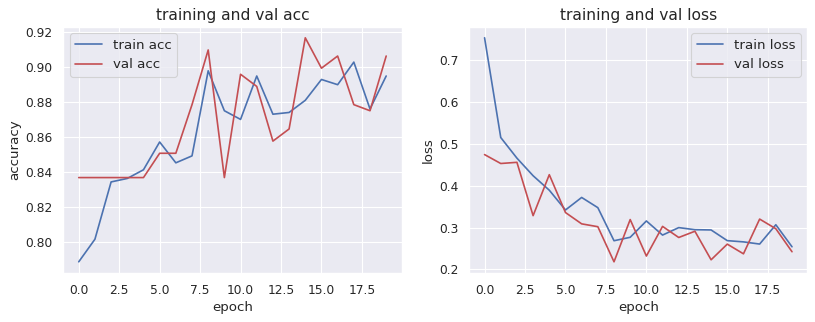

In [17]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)

    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)

    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)

    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

##学習済みモデルの重みを保存する。

In [18]:
model_save_path = '/content/drive/MyDrive/OptPhotoFiles/model_checkpoint'
torch.save(model.state_dict(), model_save_path)

##任意の画像を呼び出して推論を行う。

推論に使用された画像の特徴量をAttention_Mapを使用して可視化する。

In [19]:
# 画像のパス
image_path = '/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles_modified/RA_right/patients_000009.out.jpg'

# 画像の読み込み
image = Image.open(image_path).convert("RGB")

# 前処理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_tensor = transform(image).unsqueeze(0).to(device)

In [20]:
def hook_fn(module, input, output):
    # Q, K, Vを取得
    Q, K, V = input[0].chunk(3, dim=-1)

    # Scaled Dot-Product
    attn_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(K.size(-1))

    # Softmax適用
    attn_weight = torch.nn.functional.softmax(attn_score, dim=-1)

    # 注意マップを格納
    attentions.append(attn_weight)

    # attn_weightの形状を出力
    print(attn_weight.shape)


torch.Size([1, 785, 785])


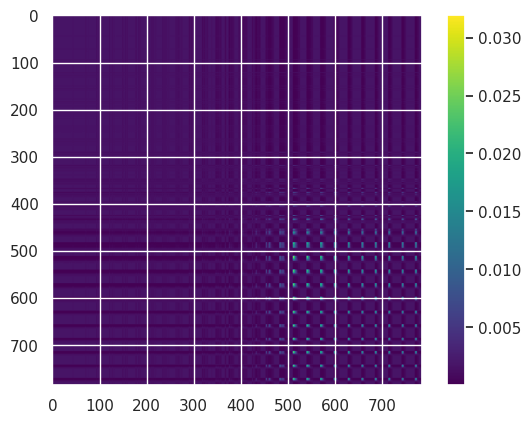

In [21]:
import math

# ViTモデルの取得
#model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)  # 2クラス分類用に変更

# 重みの読み込み
#model.load_state_dict(torch.load(model_save_path))
#model.eval()
#model = model.to(device)

# 注意マップを格納するリスト
attentions = []

# フックをQKVのLinear層に設定
hook = model.blocks[0].attn.qkv.register_forward_hook(hook_fn)

# モデルの推論
with torch.no_grad():
    outputs = model(image_tensor)

# フックを削除
hook.remove()

# 注意マップを取得
#attn_map = attentions[0].squeeze().cpu().numpy()
attn_map = attentions[0][0].squeeze().cpu().detach().numpy()  # Taking the first data in the batch

# 注意マップを描画
plt.imshow(attn_map, cmap='viridis')
plt.colorbar()
plt.show()

torch.Size([1, 785, 785])
torch.Size([1, 785, 785])
torch.Size([1, 785, 785])
torch.Size([1, 785, 785])
torch.Size([1, 785, 785])
torch.Size([1, 785, 785])
torch.Size([1, 785, 785])
torch.Size([1, 785, 785])
torch.Size([1, 785, 785])
torch.Size([1, 785, 785])
torch.Size([1, 785, 785])
torch.Size([1, 785, 785])


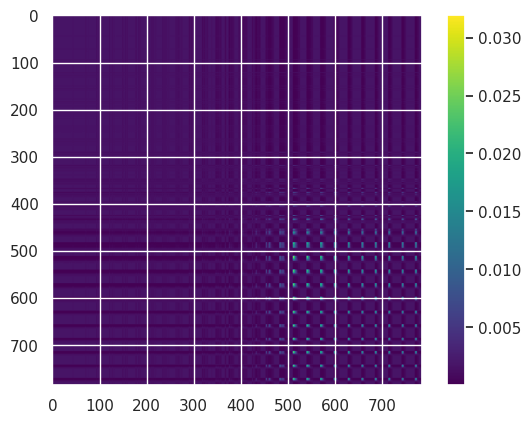

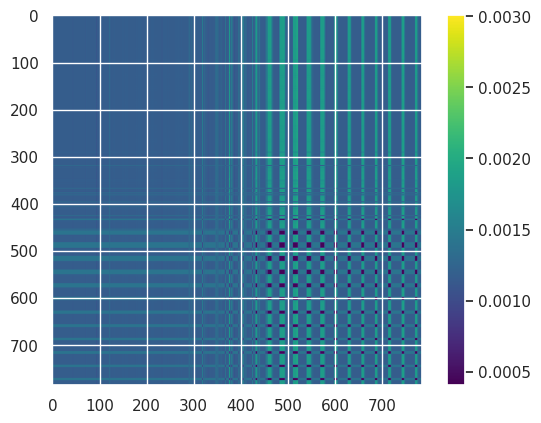

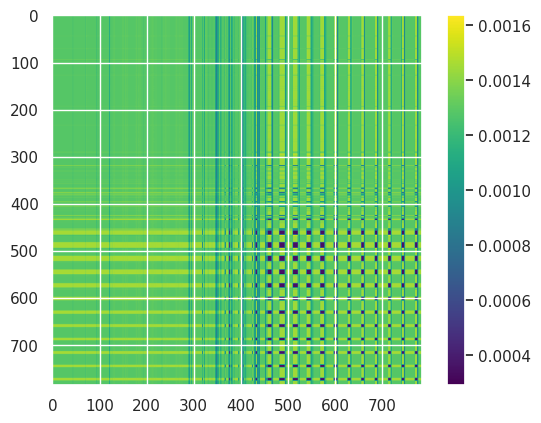

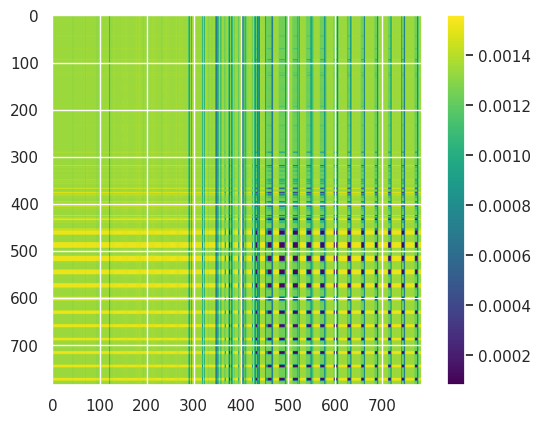

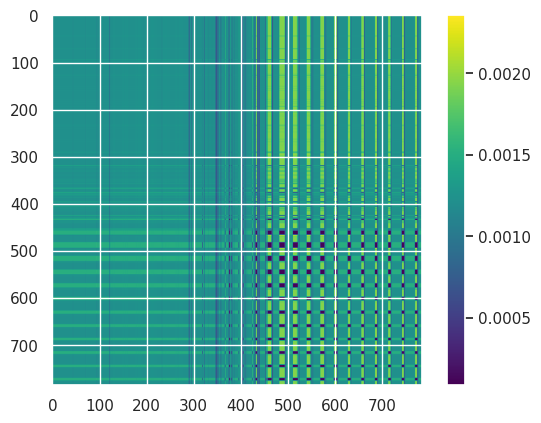

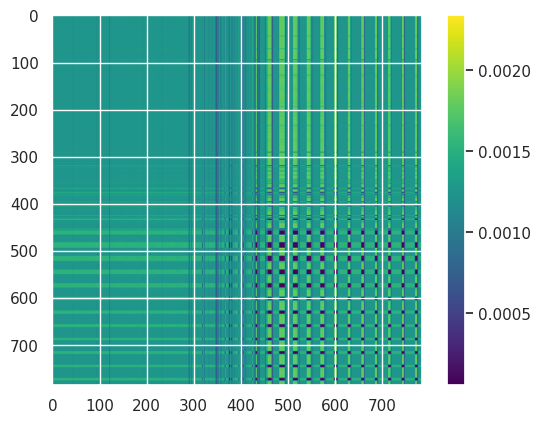

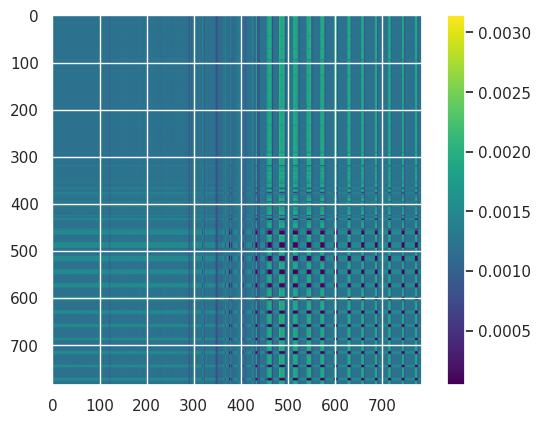

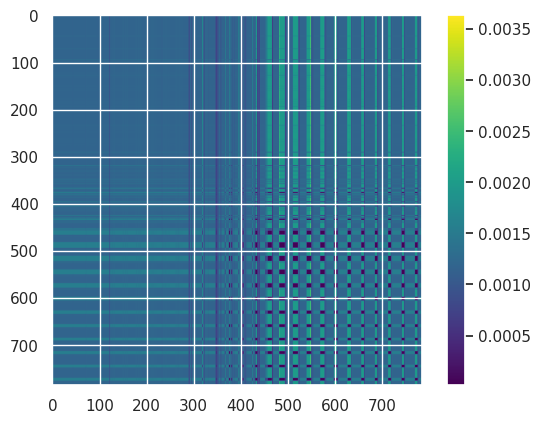

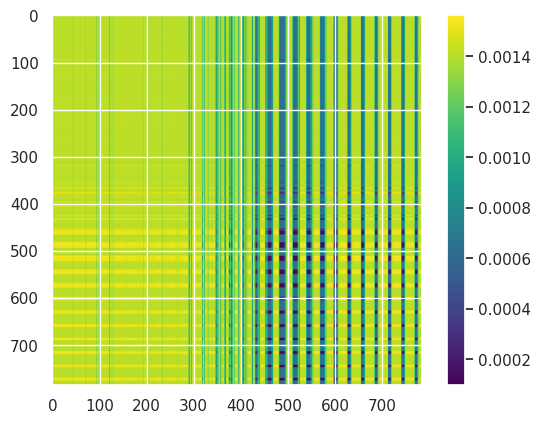

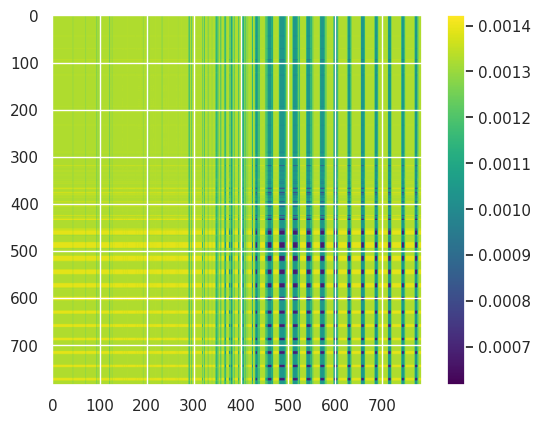

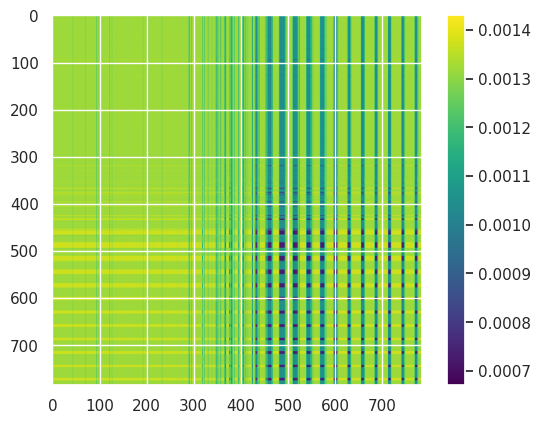

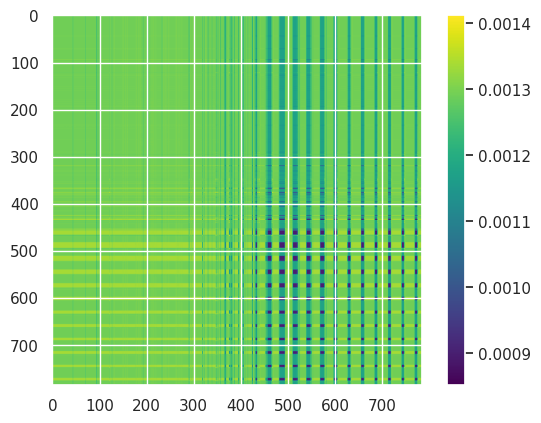

In [22]:
# 注意マップを格納するリスト
attentions = []

# モデル内のすべてのトランスフォーマーブロックにフックを設定
hooks = []
for block in model.blocks:
    hooks.append(block.attn.qkv.register_forward_hook(hook_fn))

# モデルの推論
with torch.no_grad():
    outputs = model(image_tensor)

# フックをすべて削除
for hook in hooks:
    hook.remove()

# 各ブロックの注意マップを描画
for attn in attentions:
    attn_map = attn[0].squeeze().cpu().detach().numpy()  # Taking the first data in the batch
    plt.imshow(attn_map, cmap='viridis')
    plt.colorbar()
    plt.show()

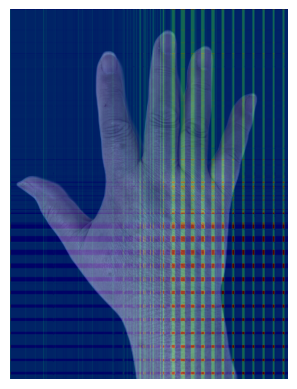

In [23]:
import cv2

# 元の画像を読み込む
original_image = cv2.imread('/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles_modified/RA_right/patients_000009.out.jpg')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# 画像のサイズを取得
height, width, _ = original_image.shape

# 注意マップのサイズを画像のサイズに合わせてリサイズ
# 注意: ここでは197x197の注意マップを例としています。
upsampled_attn_map = cv2.resize(attn_map, (width, height))

# 元の画像に注意マップを重ねる
heatmap = (upsampled_attn_map - upsampled_attn_map.min()) / (upsampled_attn_map.max() - upsampled_attn_map.min())
heatmap = cv2.applyColorMap((heatmap * 255).astype('uint8'), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap, 0.4, 0)

plt.imshow(superimposed_img)
plt.axis('off')
plt.show()
